In [153]:
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape
import asf_search as asf
from datetime import datetime, date, timedelta
from typing import List
from pystac_client import Client, ItemSearch
import geopandas as gpd
from rasterio.crs import CRS
import contextily as cx
import pandas as pd
from shapely.ops import cascaded_union
from itertools import combinations

In [2]:
# for formatting the datetime object to asfsearch syntax
def datetime2asfsearch(entered_date: datetime) -> str:
    return datetime.strftime(entered_date,'%Y') + '-' + datetime.strftime(entered_date,'%m') + '-' + datetime.strftime(entered_date,'%d') + 'T' + datetime.strftime(entered_date,'%H') + ':' + datetime.strftime(entered_date,'%M') + ':' + datetime.strftime(entered_date,'%S') + 'Z'

In [3]:
# for formatting the asfsearch syntax to datetime object
def asfsearch2datetime(entered_date: str) -> datetime:
    try:
        dtime = datetime.strptime(entered_date, '%Y-%m-%dT%H:%M:%S.%f')
    except:
        dtime = datetime.strptime(entered_date, '%Y-%m-%dT%H:%M:%S.%fZ')
    return dtime

In [123]:
# for searching for sentinel2 and landsat8 data
def hls_search(sensor: str, aoi: Polygon, date: List[datetime] = None):
    STAC_URL = 'https://cmr.earthdata.nasa.gov/stac'
    api = Client.open(f'{STAC_URL}/LPCLOUD/')
    
    if 'sentinel2' in sensor.lower():
        hls_collections = ['HLSS30.v2.0']
    elif 'landsat8' in sensor.lower():
        hls_collections = ['HLSL30.v2.0']
    
    if date == None:
        search_datetime = [datetime.combine(date.today(), datetime.min.time()), datetime.now()]
    else:
        search_datetime = date
    
    x, y = aoi.exterior.coords.xy
    
    search_params = {
        "collections": hls_collections,
        "bbox": [x[0],y[0],x[1],y[1]], # list of xmin, ymin, xmax, ymax
        "datetime": search_datetime,
    }
    search_hls = api.search(**search_params)
    hls_collection = search_hls.get_all_items()
    d = list(hls_collection)
    
    return d

In [142]:
# for searching sentinel1 data
def asf_search(aoi: Polygon, date: datetime = None):
    if date == None:
        today = date.today()
        start = str(today) + 'T00:00:00Z'
        end = str(today) + 'T23:59:59Z'
    else:
        start = datetime2asfsearch(date[0])
        end = datetime2asfsearch(date[1])

    wkt = aoi.wkt
    opts = {
        'platform': asf.PLATFORM.SENTINEL1,
        'processingLevel': [asf.PRODUCT_TYPE.SLC],
        'beamMode': [asf.BEAMMODE.IW],
        'start': start,
        'end': end
    }
    results = asf.geo_search(intersectsWith=wkt,**opts)
    
    return results

In [51]:
# find next acquisition date
def acq_search(sensor_name: str, aoi: Polygon, date):
    
    # put arbitrary hard stop at 3 searches (15 days)
    for rep in range(3):

        if 'landsat8' in sensor_name.lower():
            results = hls_search('landsat8', aoi, [date + timedelta(days = 5 * rep), date + timedelta(days = 5 * (rep + 1))])
        elif 'sentinel1' in sensor_name.lower():
            results = asf_search(aoi, [date + timedelta(days = 5 * rep), date + timedelta(days = 5 * (rep + 1))])
        elif 'sentinel2' in sensor_name.lower():
            results = hls_search('sentinel2', aoi, [date + timedelta(days = 5 * rep), date + timedelta(days = 5 * (rep + 1))])
        
        coords = [r.geometry['coordinates'][0] for r in results]
            
        if coords:
            break
    
    # extract time of next acquisition
    if coords:

        try:
            next_acq = results[i].properties['start_datetime']
        except:
            next_acq = results[i].properties['startTime']

    else:
        next_acq = 'Search yielded no results'
    
    return next_acq

In [52]:
# calculate cadence
def get_cadence(results):
    
    cadence = ''
    if len(results) == 0:
        cadence = 'There is no coverage during this time'

    else:
        if len(results) == 1:
            try:
                cadence = 'Only one acquisition on ' + results[0].properties['startTime']
            except:
                cadence = 'Only one acquisition on ' + results[0].properties['start_datetime']

        else:
            cadence = []
            for i in range(len(results) - 1):
                try:
                    cadence.append(str(asfsearch2datetime(results[i].properties['startTime']) - asfsearch2datetime(results[i + 1].properties['startTime'])))
                except:
                    cadence.append(str(asfsearch2datetime(results[i + 1].properties['start_datetime']) - asfsearch2datetime(results[i].properties['start_datetime'])))
        
    return cadence

In [202]:
# reformat results from asf_search list to geodataframe
def format_results_for_sent1(results: list) -> gpd.GeoDataFrame:
    geometry = [shape(r.geojson()['geometry']) for r in results]
    data = [r.properties for r in results]

    df = pd.DataFrame(data)
    df = gpd.GeoDataFrame(df, geometry=geometry, crs=CRS.from_epsg(4326))

    if df.empty:
        warn('Dataframe is empty! Check inputs.')
        return df

    df['startTime'] = pd.to_datetime(df.startTime)
    df['stopTime'] = pd.to_datetime(df.stopTime)
    df['start_date'] = pd.to_datetime(df.startTime.dt.date)
    df['start_date_str'] = df.start_date.dt.date.map(str)
    df['pathNumber'] = df['pathNumber'].astype(int)
    df.drop(columns=['browse'], inplace=True)
    df = df.sort_values(by=['startTime', 'pathNumber']).reset_index(drop=True)

    return df

In [201]:
def format_results_for_hls(results: list) -> gpd.GeoDataFrame:
    geometry = [shape(r.geometry) for r in results]
    data = [r.properties for r in results]

    df = pd.DataFrame(data)
    df = gpd.GeoDataFrame(df, geometry=geometry, crs=CRS.from_epsg(4326))

    if df.empty:
        warn('Dataframe is empty! Check inputs.')
        return df
    
    print(df)
    df['startTime'] = pd.to_datetime(df.start_datetime.replace('Z',''))
    df['stopTime'] = pd.to_datetime(df.end_datetime.replace('Z',''))
    print(df.start_datetime)
#     df['start_date'] = pd.to_datetime(df.start_datetime.replace('Z','').dt.date)
#     df['start_date_str'] = df.start_datetime.replace('Z','').dt.date.map(str)
    df = df.sort_values(by=['startTime']).reset_index(drop=True)

    return df

In [149]:
def get_coverage(sensor: List[str], aoi: Point, date: List[datetime] = None) -> List[dict]:
    """
    Sensor: choose sentinel1, sentinel2, landsat8
    AOI: enter coordinates as Polygon object
    date: leave as none if searching today, else enter time range as datetime tuple: datetime(YYYY,MM,DD)
    """
    freq = {}
    next_acq = {}
    area = {}
    coord = {}
    
    for sensor_name in sensor:
        freq[sensor_name] = ''
        next_acq[sensor_name] = ''
        area[sensor_name] = ''
        coord[sensor_name] = ''
        
        if 'landsat8' in sensor_name.lower():
            results = hls_search('landsat8', aoi, date)
        elif 'sentinel1' in sensor_name.lower():
            results = asf_search(aoi, date)
        elif 'sentinel2' in sensor_name.lower():
            results = hls_search('sentinel2', aoi, date)
        
        if 'sentinel1' in sensor_name.lower():
            for i in range(len(results)):
                print(results[i].properties['frameNumber'])
        
        coords = [r.geometry['coordinates'][0] for r in results]
        coord[sensor_name] = coords
        
        # return cadence as string or list using get_cadence
        freq[sensor_name] = get_cadence(results)
        
        # find next acquisition time, if search time is today then returns 'N/A'
        if date == None:
            next_acq[sensor_name] = 'N/A'
            
        else:
            next_acq[sensor_name] = acq_search(sensor_name.lower(), aoi, date[1])
        
        # find area intersection for each sensor
        if len(results) == 0:
            area[sensor_name] = 0
        else:
            area[sensor_name] = Polygon(coords[0])
            
            if len(results) > 1:
                
                for i in range(len(coords) - 1):
                    area[sensor_name] = area[sensor_name].intersection(Polygon(coords[i + 1]))
         
    return freq, next_acq, area, coords

### Polygons of areas of interest:

Ridgecrest coordinates: Polygon([[-117.7167, 35.5909],[-117.6322, 35.5909],[-117.6322, 35.6452],[-117.7167, 35.6452],[-117.7167, 35.5909]])

Wax lake delta: Polygon([[-91.4964, 29.4641],[-91.3849, 29.4641],[-91.3849, 29.5627],[-91.4964, 29.5627],[-91.4964, 29.4641]])

Laurentides forest in Canada: Polygon([[-75.0327, 46.0832],[-74.8823, 46.0832],[-74.8823, 46.1914],[-75.0327, 46.1914],[-75.0327, 46.0832]])

In [147]:
freq3, next_acq3, area3, coord3 = get_coverage(['sentinel1','sentinel2','landsat8'],Polygon([[-75.0327, 46.0832],[-74.8823, 46.0832],[-74.8823, 46.1914],[-75.0327, 46.1914],[-75.0327, 46.0832]]),[datetime(2022,1,1), datetime(2022,2,1)])

145
145


In [209]:
forest = Polygon([[-75.0327, 46.0832],[-74.8823, 46.0832],[-74.8823, 46.1914],[-75.0327, 46.1914],[-75.0327, 46.0832]])

In [212]:
data = {}
data['date'] = '2022-01-01'
data['empty'] = 'this'
dataframe = pd.DataFrame(data)
dataframe = pd.GeoDataFrame(dataframe, geometry = forest, crs=CRS.from_epsg(4326))

ValueError: If using all scalar values, you must pass an index

### Work in progress

In [148]:
print(freq3['landsat8'])
print(next_acq3['landsat8'])
print(freq3['sentinel1'])
print(next_acq3['sentinel1'])
print(freq3['sentinel2'])
print(next_acq3['sentinel2'])

['0:00:00', '7 days, 0:06:09.592000', '0:00:00', '8 days, 23:53:45.752000', '0:00:00', '7 days, 0:06:09.381000', '0:00:00']
2022-02-09T15:44:10.497Z
['11 days, 23:59:59']
2022-02-03T22:52:35.000000
['0:00:04.401000', '4 days, 23:59:49.942000', '0:00:04.398000', '1 day, 23:50:04.587000', '0:00:03.261000', '3 days, 0:09:52.701000', '0:00:04.405000', '1 day, 23:49:54.053000', '0:00:03.264000', '3 days, 0:09:52.691000', '0:00:04.402000', '1 day, 23:50:03.846000', '0:00:03.266000', '3 days, 0:09:53.157000', '0:00:04.402000', '1 day, 23:49:53.480000', '0:00:03.269000', '3 days, 0:09:52.650000', '0:00:04.407000', '1 day, 23:50:05.581000', '0:00:03.264000']
2022-02-04T16:00:18.398Z


In [206]:
df_1 = format_results_for_hls(d)

                   datetime            start_datetime  \
0  2022-01-08T15:44:18.159Z  2022-01-08T15:44:18.159Z   
1  2022-01-08T15:44:18.159Z  2022-01-08T15:44:18.159Z   
2  2022-01-15T15:50:27.751Z  2022-01-15T15:50:27.751Z   
3  2022-01-15T15:50:27.751Z  2022-01-15T15:50:27.751Z   
4  2022-01-24T15:44:13.503Z  2022-01-24T15:44:13.503Z   
5  2022-01-24T15:44:13.503Z  2022-01-24T15:44:13.503Z   
6  2022-01-31T15:50:22.884Z  2022-01-31T15:50:22.884Z   
7  2022-01-31T15:50:22.884Z  2022-01-31T15:50:22.884Z   

               end_datetime  eo:cloud_cover  \
0  2022-01-08T15:44:42.038Z              27   
1  2022-01-08T15:44:42.038Z               5   
2  2022-01-15T15:50:51.633Z              24   
3  2022-01-15T15:50:51.633Z              13   
4  2022-01-24T15:44:37.390Z              98   
5  2022-01-24T15:44:37.390Z              75   
6  2022-01-31T15:50:46.762Z              27   
7  2022-01-31T15:50:46.762Z              13   

                                            geometry  
0  POLY

In [221]:
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


<AxesSubplot:>

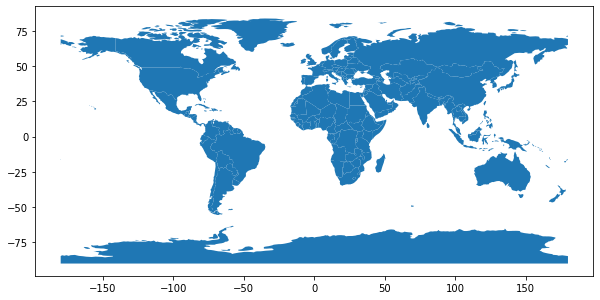

In [228]:
world.plot(figsize=(10,10))

In [223]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<AxesSubplot:>

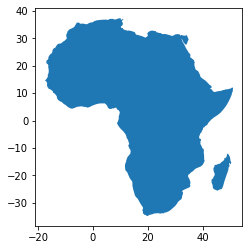

In [232]:
df_cont = world.dissolve(by='continent').reset_index()
df_cont.iloc[:1].plot()

In [ ]:
wo

<AxesSubplot:>

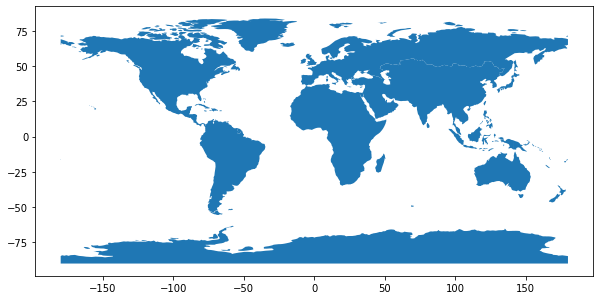

In [227]:
world.dissolve(by='continent').plot(figsize=(10,10))
# world.plot()

In [ ]:
world.p

In [213]:
df_1.head()

,datetime,start_datetime,end_datetime,eo:cloud_cover,geometry,startTime,stopTime
0,2022-01-08T15:44:18.159Z,2022-01-08T15:44:18.159Z,2022-01-08T15:44:42.038Z,27,"POLYGON ((-75.74016 45.96315, -74.87403 45.965...",2022-01-08 15:44:18.159000+00:00,2022-01-08 15:44:42.038000+00:00
1,2022-01-08T15:44:18.159Z,2022-01-08T15:44:18.159Z,2022-01-08T15:44:42.038Z,5,"POLYGON ((-73.58334 45.95677, -73.55749 46.944...",2022-01-08 15:44:18.159000+00:00,2022-01-08 15:44:42.038000+00:00
2,2022-01-15T15:50:27.751Z,2022-01-15T15:50:27.751Z,2022-01-15T15:50:51.633Z,24,"POLYGON ((-76.29100 45.95826, -74.87403 45.965...",2022-01-15 15:50:27.751000+00:00,2022-01-15 15:50:51.633000+00:00
3,2022-01-15T15:50:27.751Z,2022-01-15T15:50:27.751Z,2022-01-15T15:50:51.633Z,13,"POLYGON ((-74.79698 45.96537, -74.40336 46.952...",2022-01-15 15:50:27.751000+00:00,2022-01-15 15:50:51.633000+00:00
4,2022-01-24T15:44:13.503Z,2022-01-24T15:44:13.503Z,2022-01-24T15:44:37.390Z,98,"POLYGON ((-75.73899 45.96316, -74.87403 45.965...",2022-01-24 15:44:13.503000+00:00,2022-01-24 15:44:37.390000+00:00


In [197]:
df.head()

,beamModeType,bytes,centerLat,centerLon,faradayRotation,fileID,fileName,flightDirection,frameNumber,granuleType,...,processingLevel,sceneName,sensor,startTime,stopTime,temporalBaseline,url,geometry,start_date,start_date_str
0,IW,4402366634,36.2505,-117.9358,None,S1A_IW_SLC__1SDV_20220101T015100_20220101T0151...,S1A_IW_SLC__1SDV_20220101T015100_20220101T0151...,ASCENDING,114,SENTINEL_1A_FRAME,...,SLC,S1A_IW_SLC__1SDV_20220101T015100_20220101T0151...,C-SAR,2022-01-01 01:51:00,2022-01-01 01:51:27,None,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,"POLYGON ((-116.70898 37.25085, -116.38108 35.6...",2022-01-01,2022-01-01
1,IW,4379405228,35.1339,-117.5335,None,S1A_IW_SLC__1SDV_20220101T135218_20220101T1352...,S1A_IW_SLC__1SDV_20220101T135218_20220101T1352...,DESCENDING,475,SENTINEL_1A_FRAME,...,SLC,S1A_IW_SLC__1SDV_20220101T135218_20220101T1352...,C-SAR,2022-01-01 13:52:18,2022-01-01 13:52:46,None,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,"POLYGON ((-119.08044 34.48653, -118.74294 36.1...",2022-01-01,2022-01-01
2,IW,4385168449,36.2503,-117.9371,None,S1A_IW_SLC__1SDV_20220113T015100_20220113T0151...,S1A_IW_SLC__1SDV_20220113T015100_20220113T0151...,ASCENDING,114,SENTINEL_1A_FRAME,...,SLC,S1A_IW_SLC__1SDV_20220113T015100_20220113T0151...,C-SAR,2022-01-13 01:51:00,2022-01-13 01:51:27,None,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,"POLYGON ((-116.71032 37.25084, -116.38232 35.6...",2022-01-13,2022-01-13
3,IW,4361047217,35.1339,-117.5334,None,S1A_IW_SLC__1SDV_20220113T135218_20220113T1352...,S1A_IW_SLC__1SDV_20220113T135218_20220113T1352...,DESCENDING,475,SENTINEL_1A_FRAME,...,SLC,S1A_IW_SLC__1SDV_20220113T135218_20220113T1352...,C-SAR,2022-01-13 13:52:18,2022-01-13 13:52:45,None,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,"POLYGON ((-119.08031 34.48656, -118.74277 36.1...",2022-01-13,2022-01-13
4,IW,4391776002,36.25,-117.937,None,S1A_IW_SLC__1SDV_20220125T015059_20220125T0151...,S1A_IW_SLC__1SDV_20220125T015059_20220125T0151...,ASCENDING,114,SENTINEL_1A_FRAME,...,SLC,S1A_IW_SLC__1SDV_20220125T015059_20220125T0151...,C-SAR,2022-01-25 01:50:59,2022-01-25 01:51:26,None,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,"POLYGON ((-116.71029 37.25055, -116.38228 35.6...",2022-01-25,2022-01-25


### The below cells are just for reminding what format the output results have

In [192]:
df = format_results_for_sent1(results)

0   2022-01-25 13:52:17
1   2022-01-25 01:50:59
2   2022-01-13 13:52:18
3   2022-01-13 01:51:00
4   2022-01-01 13:52:18
5   2022-01-01 01:51:00
Name: startTime, dtype: datetime64[ns]


In [203]:
STAC_URL = 'https://cmr.earthdata.nasa.gov/stac'
api = Client.open(f'{STAC_URL}/LPCLOUD/')
hls_collections = ['HLSL30.v2.0']
search_params = {"collections": hls_collections,
                 "bbox": [-75.0327, 46.0832, -74.8823, 46.1914], # list of xmin, ymin, xmax, ymax
                 "datetime": [datetime(2022,1,1), datetime(2022,2,1)],
                 }
search_hls = api.search(**search_params)
hls_collection = search_hls.get_all_items()
d = list(hls_collection)
d[0].properties

{'datetime': '2022-01-08T15:44:18.159Z',
 'start_datetime': '2022-01-08T15:44:18.159Z',
 'end_datetime': '2022-01-08T15:44:42.038Z',
 'eo:cloud_cover': 27}

In [215]:
dir(d[0])

['STAC_OBJECT_TYPE',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_object_links',
 'add_asset',
 'add_link',
 'add_links',
 'assets',
 'bbox',
 'clear_links',
 'clone',
 'collection_id',
 'common_metadata',
 'datetime',
 'extra_fields',
 'from_dict',
 'from_file',
 'full_copy',
 'geometry',
 'get_assets',
 'get_collection',
 'get_datetime',
 'get_links',
 'get_parent',
 'get_root',
 'get_root_link',
 'get_self_href',
 'get_single_link',
 'get_stac_objects',
 'id',
 'links',
 'make_asset_hrefs_absolute',
 'make_asset_hrefs_relative',
 'matches_object_type',
 'properties',
 'remove_links',
 'reso

In [216]:
d[0].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'HLS.L30.T18TVS.2022008T154418.v2.0',
 'properties': {'datetime': '2022-01-08T15:44:18.159000Z',
  'start_datetime': '2022-01-08T15:44:18.159Z',
  'end_datetime': '2022-01-08T15:44:42.038Z',
  'eo:cloud_cover': 27},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-75.7401564, 45.9631543],
    [-74.8740327, 45.9654817],
    [-74.871733, 46.9536373],
    [-75.3921562, 46.9530376],
    [-75.7401564, 45.9631543]]]},
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSL30.v2.0/items/HLS.L30.T18TVS.2022008T154418.v2.0'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSL30.v2.0'},
  {'rel': 'collection',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSL30.v2.0'},
  {'rel': <RelType.ROOT: 'root'>,
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/',
   'type': <MediaType.JSON: 'application/json'>,
   'title': 'LPCLOUD'},

In [217]:
d[1].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'HLS.L30.T18TWS.2022008T154418.v2.0',
 'properties': {'datetime': '2022-01-08T15:44:18.159000Z',
  'start_datetime': '2022-01-08T15:44:18.159Z',
  'end_datetime': '2022-01-08T15:44:42.038Z',
  'eo:cloud_cover': 5},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-73.5833439, 45.9567699],
    [-73.5574919, 46.9446214],
    [-75.0002628, 46.9537092],
    [-75.0002581, 45.9655512],
    [-73.5833439, 45.9567699]]]},
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSL30.v2.0/items/HLS.L30.T18TWS.2022008T154418.v2.0'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSL30.v2.0'},
  {'rel': 'collection',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSL30.v2.0'},
  {'rel': <RelType.ROOT: 'root'>,
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/',
   'type': <MediaType.JSON: 'application/json'>,
   'title': 'LPCLOUD'},

In [218]:
d[1].id,d[0].id

('HLS.L30.T18TWS.2022008T154418.v2.0', 'HLS.L30.T18TVS.2022008T154418.v2.0')

In [219]:
df = format_results_for_hls(d[:2])

                      datetime            start_datetime  \
0  2022-01-08T15:44:18.159000Z  2022-01-08T15:44:18.159Z   
1  2022-01-08T15:44:18.159000Z  2022-01-08T15:44:18.159Z   

               end_datetime  eo:cloud_cover  \
0  2022-01-08T15:44:42.038Z              27   
1  2022-01-08T15:44:42.038Z               5   

                                            geometry  
0  POLYGON ((-75.74016 45.96315, -74.87403 45.965...  
1  POLYGON ((-73.58334 45.95677, -73.55749 46.944...  
0    2022-01-08T15:44:18.159Z
1    2022-01-08T15:44:18.159Z
Name: start_datetime, dtype: object


In [220]:
df.iloc[:2].to_file('test2.geojson',driver='GeoJSON')

In [205]:
for i in range(len(d)):
    print(d[i].properties['datetime'])

2022-01-08T15:44:18.159Z
2022-01-08T15:44:18.159Z
2022-01-15T15:50:27.751Z
2022-01-15T15:50:27.751Z
2022-01-24T15:44:13.503Z
2022-01-24T15:44:13.503Z
2022-01-31T15:50:22.884Z
2022-01-31T15:50:22.884Z


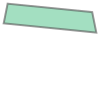

In [51]:
from shapely.geometry import shape
shape(area1['sentinel1'])

# Visualization

In [115]:
# returns filled-in plot or outline of dictionary of polygons (or single polygon) with world map underneath
def visual(area, outline = False):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    
    if type(area) == dict:
        
        color = ['blue','green','red']
    
        for num,frame in enumerate(area.keys()):
            df = gpd.GeoDataFrame(geometry = [area[frame]],
                                  crs = CRS.from_epsg(4326))
            df_wm = df.to_crs(epsg = 3857)
            if not outline:
                df_wm.plot(ax = ax, alpha = .3, color=color[num], legend = True)
            else:
                df_wm.boundary.plot(ax = ax, color=color[num])
            
    elif type(area) == Polygon:
        
        df = gpd.GeoDataFrame(geometry = [area],
                                  crs = CRS.from_epsg(4326))
        df_wm = df.to_crs(epsg = 3857)
        if not outline:
            df_wm.plot(ax = ax, alpha = .3)
        else:
            df_wm.boundary.plot(ax = ax)
    
    cx.add_basemap(ax, zoom = 10)

In [117]:
# returns plot of intersection of all polygons in input dictionary
def find_overlap(area: dict, outline = False):
    
    for idx,key in enumerate(area.keys()):
        if idx == 0:
            overlap = area[key]
        else:
            overlap = overlap.intersection(area[key])
            
    visual(overlap, outline)

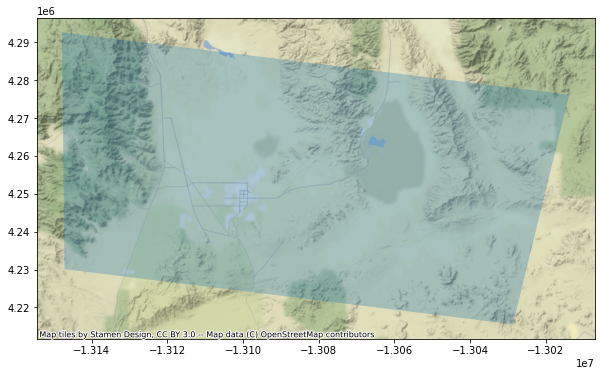

In [119]:
find_overlap(area1)

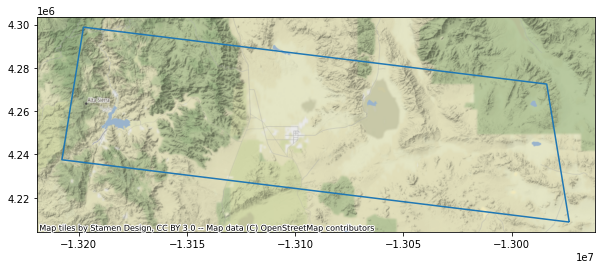

In [116]:
visual(area1['sentinel1'],outline=True)

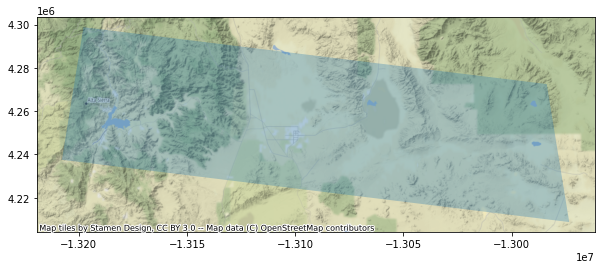

In [96]:
visual(area1['sentinel1'])

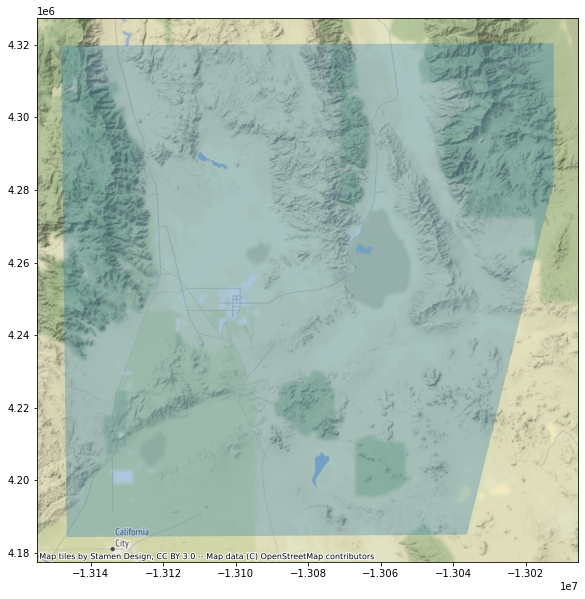

In [102]:
visual(area1['landsat8'])

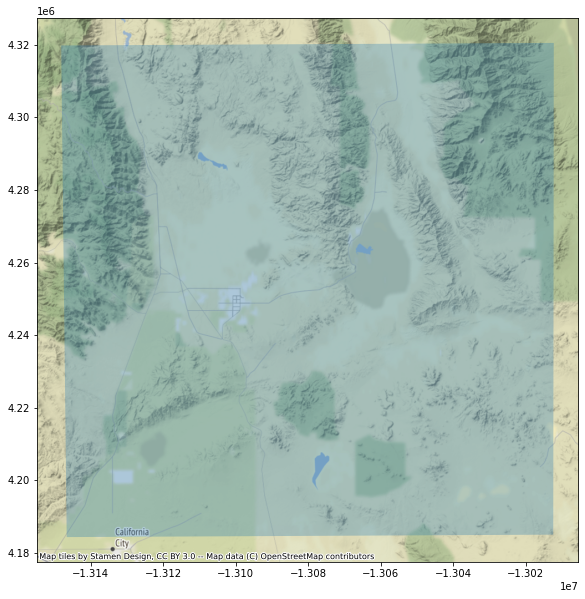

In [103]:
visual(area1['sentinel2'])

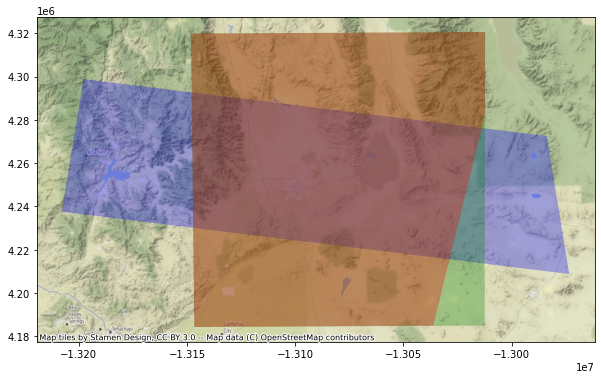

In [99]:
visual(area1)

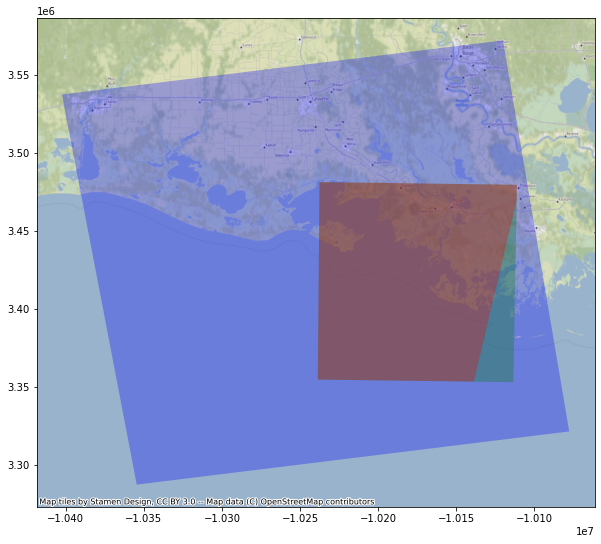

In [100]:
visual(area2)

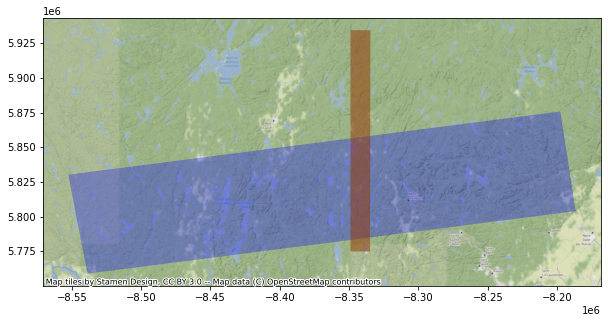

In [101]:
visual(area3)

### Deprecated